# Praca domowa nr 2, Warsztaty Badawcze ML 2



Jędrzej Sokołowski 31.03.2022

### Wczytanie danych oraz potrzebnych pakietów

In [468]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

cat_test_df = pd.read_csv("test_cat.csv")
cat_train_df = pd.read_csv("train_cat.csv")
cars_df = pd.read_csv("Car_Prices_Poland.csv")

## Wstęp

Poniższy raport przestawia testowanie modeli `Random Forest` oraz `XGBoost` na zadaniach klasyfikacji i regresji dotyczących zbiorów danych posiadających informacje o pasażerach lini lotniczych oraz cenach samochodów w Polsce.

## Dane z zadaniem klasyfikacji

In [429]:
cat_test_df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [381]:
cat_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [382]:
print(cat_train_df[cat_train_df["Arrival Delay in Minutes"].isna()].shape[0]/cat_train_df.shape[0])
print(cat_test_df[cat_test_df["Arrival Delay in Minutes"].isna()].shape[0]/cat_test_df.shape[0])

0.00298352325223283
0.0031952571604558053


In [383]:
cat_train_df["satisfaction"].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

Jedyne braki w postaci `NaN` występują w kolumnie `Arrival Delay in Minutes`, jako że te wiersze w odpowiadają za mniej niż jeden procent danych, zostaną one usunięte. Zmienna celu przyjmuje tylko dwie wartości, dlatego zakodujemy ją binarnie. Podobnie zrobimy z kolumną `Gender`. Kolumny numeryczne zostaną przeskalowane.

In [384]:
le_train = LabelEncoder()
le_test = LabelEncoder()

integer_encoded_train = le_train.fit_transform(cat_train_df["satisfaction"])
integer_encoded_test = le_test.fit_transform(cat_test_df["satisfaction"])

cat_train_df["satisfaction"] = integer_encoded_train
cat_test_df["satisfaction"] = integer_encoded_test

cat_train_df['Gender'] = (cat_train_df['Gender'] == 'Female')*1
cat_test_df['Gender'] = (cat_test_df['Gender'] == 'Female')*1

In [385]:
cat_test_df = cat_test_df.drop(columns = ["Unnamed: 0", "id"], axis=1)
cat_train_df = cat_train_df.drop(columns = ["Unnamed: 0", "id"], axis=1)

cat_test_df = cat_test_df[~cat_test_df["Arrival Delay in Minutes"].isna()]
cat_train_df = cat_train_df[~cat_train_df["Arrival Delay in Minutes"].isna()]

numeric_columns = list(cat_train_df._get_numeric_data().columns)
numeric_columns.remove('satisfaction')
numeric_columns.remove('Gender')
print(numeric_columns)

for col in numeric_columns:
    transf1 = cat_test_df[col].values.reshape(-1,1)
    scaler1 = StandardScaler().fit(transf1)
    cat_test_df[col] = scaler1.transform(transf1)
    
    transf2 = cat_train_df[col].values.reshape(-1,1)
    scaler2 = StandardScaler().fit(transf2)
    cat_train_df[col] = scaler2.transform(transf2)
    
encoded_test = pd.get_dummies(cat_test_df[["Customer Type","Type of Travel", "Class"]].astype(str))
encoded_test = encoded_test.drop(["Customer Type_Loyal Customer", "Type of Travel_Business travel", "Class_Business"], axis = 1)

cat_test_df = cat_test_df.drop(["Customer Type","Type of Travel", "Class"], axis=1)
cat_test_df = pd.concat([cat_test_df, encoded_test], axis = 1)

encoded_train = pd.get_dummies(cat_train_df[["Customer Type","Type of Travel", "Class"]].astype(str))
encoded_train = encoded_train.drop(["Customer Type_Loyal Customer", "Type of Travel_Business travel", "Class_Business"], axis = 1)

cat_train_df = cat_train_df.drop(["Customer Type","Type of Travel", "Class"], axis=1)
cat_train_df = pd.concat([cat_train_df, encoded_train], axis = 1)

['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [386]:
cat_train_df.head()

,Gender,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,0,-1.745542,-0.731305,0.203521,0.616249,0.173716,-1.547312,1.352401,-0.185632,1.182991,...,0.549773,1.156211,1.305913,0.268966,0.072905,0,0,1,0,1
1,0,-0.951526,-0.956916,0.203521,-0.695032,0.173716,0.017981,-1.656487,-0.185632,-1.849863,...,-1.821038,0.305580,-1.742432,-0.360682,-0.237184,0,1,0,0,0
2,1,-0.885358,-0.047454,-0.549571,-0.695032,-0.541118,-0.764666,1.352401,1.296479,1.182991,...,0.549773,0.305580,1.305913,-0.386917,-0.392229,1,0,0,0,0
3,1,-0.951526,-0.629028,-0.549571,1.271890,1.603383,1.583273,-0.904265,-0.926688,-1.091649,...,-1.821038,0.305580,-0.980345,-0.098328,-0.159662,0,0,0,0,0
4,0,1.430521,-0.977973,0.203521,-0.039391,0.173716,0.017981,0.600179,1.296479,1.182991,...,-0.240497,-0.545051,-0.218259,-0.386917,-0.392229,1,0,0,0,0


### Podział danych na zbiór treningowy, walidacyjny oraz testowy

In [387]:
cat_test_df.shape[0]/cat_train_df.shape[0]

0.24994690812209203

In [388]:
y_train = cat_train_df["satisfaction"]
X_train = cat_train_df.drop("satisfaction", axis= 1)
y_test = cat_test_df["satisfaction"]
X_test = cat_test_df.drop("satisfaction", axis= 1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=420, test_size=0.125)

Proporcje dobrane sa tak by zbiory były podzielone w na 70%/10%/20%

### Model `Random Forest`

In [389]:
rndForest = RandomForestClassifier()
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_test)
print(accuracy_score(y_test, y_pred, normalize=True))

0.961147800563859


In [390]:
rndForest = RandomForestClassifier(n_estimators=20)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_test)
print(accuracy_score(y_test, y_pred, normalize=True))

0.9592940176881782


In [391]:
rndForest = RandomForestClassifier(n_estimators=5)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_test)
print(accuracy_score(y_test, y_pred, normalize=True))

0.952921639053026


In [392]:
rndForest = RandomForestClassifier(max_depth=20)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_test)
print(accuracy_score(y_test, y_pred, normalize=True))

0.9612250415170123


In [393]:
rndForest = RandomForestClassifier(max_depth=5)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_test)
print(accuracy_score(y_test, y_pred, normalize=True))

0.9202873363457305


In [394]:
rndForest = RandomForestClassifier(max_depth=2)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_test)
print(accuracy_score(y_test, y_pred, normalize=True))

0.8734406982582165


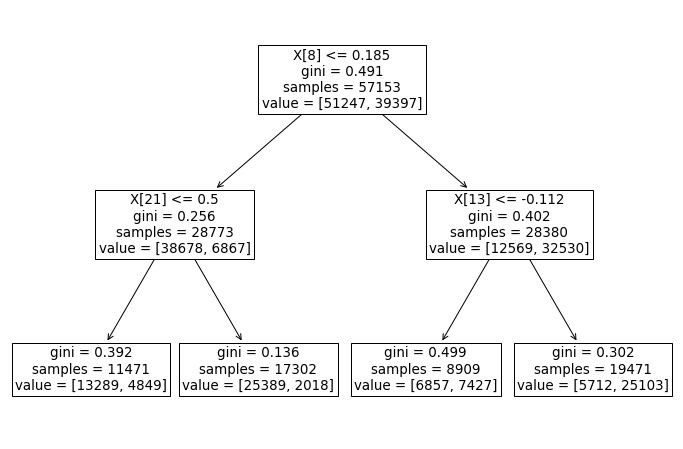

0.8423125941374117


In [395]:
rndForest = RandomForestClassifier(n_estimators = 5, max_depth=2)
rndForest.fit(X_train, y_train)
plot_tree(rndForest.estimators_[0])
plt.show()
y_pred = rndForest.predict(X_test)
print(accuracy_score(y_test, y_pred, normalize=True))

Widzimy, że dla modelu `Random Forest` dokładność wyników była całkiem dobra. Wraz z ograniczeniem hiperparametrów takich jak `max_depth` lub `n_estimators` stopniowo malała celność otrzymywanych rezultatów.

### Model `XGBoost`

In [ ]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [364]:
xgb_cls.score(X_test, y_test)

0.9622677943845827

In [ ]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", n_estimators=20, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [368]:
xgb_cls.score(X_test, y_test)

0.9540416328737497

In [ ]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", n_estimators=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [370]:
xgb_cls.score(X_test, y_test)

0.9384389603367705

In [ ]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", max_depth=20, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [372]:
xgb_cls.score(X_test, y_test)

0.9632719267755764

In [ ]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", max_depth=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [374]:
xgb_cls.score(X_test, y_test)

0.9616884872359325

In [ ]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", max_depth=2, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [376]:
xgb_cls.score(X_test, y_test)

0.944193411346696

In [ ]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", max_depth=2, n_estimators=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [378]:
xgb_cls.score(X_test, y_test)

0.8686903796392847

Widzimy, że dla modelu `GXBoost` dokładność wyników znowu była dobra. Dla niektórych wartości hiperparametrów ten model poradził sobie trochę lepiej od modelu `Random Forest`. Poza tym możemy wyciągnąć analogiczne wnioski.

## Dane z zadaniem regresji

In [430]:
cars_df.head()

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


In [431]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB


In [432]:
cars_df = cars_df.drop(columns = ["Unnamed: 0"], axis=1)

In [433]:
cars_df["years_old"] = 2022 - cars_df["year"]
cars_df.drop(columns=["year"], axis=1, inplace=True)

Jako że 25% wierszy posiada braki w kolumnie `generation_name`, przetestuje model dla dwóch zbiorów danych, takiego bez kolumny `generation_name` oraz takiego z usuniętymi wierszami zawierającymi braki.

In [434]:
cars_df[cars_df["generation_name"].isna()].shape[0]/cars_df.shape[0]

0.2551154527801097

In [435]:
cars_df_del_rows = cars_df[~cars_df["generation_name"].isna()]
cars_df_del_cols = cars_df.drop(columns=["generation_name"])

In [436]:
numeric_columns = list(cars_df._get_numeric_data().columns)
print(numeric_columns)

for col in numeric_columns:
    transf1 = cars_df_del_cols[col].values.reshape(-1,1)
    scaler1 = StandardScaler().fit(transf1)
    cars_df_del_cols[col] = scaler1.transform(transf1)
        
    transf2 = cars_df_del_rows[col].values.reshape(-1,1)
    scaler2 = StandardScaler().fit(transf2)
    cars_df_del_rows[col] = scaler2.transform(transf2)

['mileage', 'vol_engine', 'price', 'years_old']


In [437]:
numeric_columns = set(cars_df_del_rows._get_numeric_data().columns)
all_columns = set(cars_df_del_rows.columns)

cat_cols = list(all_columns.difference(numeric_columns))

print(cat_cols)
for col in cat_cols:
    
    if col != "generation_name":
        encoded1 = pd.get_dummies(cars_df_del_cols[col].astype(str), prefix=str(col))
        encoded1.drop(columns=encoded1.columns[0], axis=1, inplace=True)
        cars_df_del_cols.drop(columns=[col], axis=1, inplace=True)
        cars_df_del_cols = pd.concat([cars_df_del_cols, encoded1], axis=1) 

    encoded2 = pd.get_dummies(cars_df_del_rows[col].astype(str), prefix=str(col))
    encoded2.drop(columns=encoded2.columns[0], axis=1, inplace=True)
    cars_df_del_rows.drop(columns=[col], axis=1, inplace=True)
    cars_df_del_rows = pd.concat([cars_df_del_rows, encoded2], axis=1) 



['model', 'province', 'mark', 'city', 'generation_name', 'fuel']


In [438]:
cars_df_del_rows.shape

(87842, 4571)

In [439]:
cars_df_del_cols.shape

(117927, 4806)

In [440]:
cars_df_del_cols.head()

,mileage,vol_engine,price,years_old,model_159,model_2,model_2008,model_206,model_207,model_208,...,city_Żywocice,city_Żórawina,city_Żółwin,city_Żędowice,city_Żłobin,fuel_Diesel,fuel_Electric,fuel_Gasoline,fuel_Hybrid,fuel_LPG
0,-0.015252,-0.876396,-0.405543,-0.364622,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,-1.179896,-0.486409,0.096684,-0.891853,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.488164,-0.332589,-0.510466,-0.364622,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-1.010911,-0.876396,-0.465668,-0.540366,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-0.411142,-0.640228,-0.405543,-0.188879,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [441]:
cars_df_del_rows.head()

,mileage,vol_engine,price,years_old,model_3,model_3008,model_5,model_5008,model_6,model_80,...,generation_name_gen-w639-2003,generation_name_gen-x-2017,generation_name_gen-x164-2006-2012,generation_name_gen-x166-2012,generation_name_gen-z30-2004-2012,fuel_Diesel,fuel_Electric,fuel_Gasoline,fuel_Hybrid,fuel_LPG
0,-0.136443,-0.973247,-0.362656,-0.473920,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,-1.324679,-0.561455,0.192201,-1.008629,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.397427,-0.399034,-0.478574,-0.473920,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-1.152271,-0.973247,-0.429081,-0.652157,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-0.540353,-0.723875,-0.362656,-0.295684,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Wszystkie zminnne kategoryczne zostały zakodowane przy użyciu funkcji `get_dummies`, reszta została odpowiednio przeskalowana.

## Dane bez kolumny `generation_name`

### Podział danych na zbiór treningowy, walidacyjny oraz testowy

In [442]:
y = cars_df_del_cols["price"]
X = cars_df_del_cols.drop("price", axis= 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=420, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=420, test_size=0.125)

Proporcje dobrane sa tak by zbiory były podzielone w na 70%/10%/20%

### Model `Random Forest`

In [475]:
rndForest = RandomForestRegressor(n_jobs=-1)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.9490164656876517


In [473]:
rndForest = RandomForestRegressor(n_estimators=10)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.9467900230258272


In [472]:
rndForest = RandomForestRegressor(n_estimators=5)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.9474338383624863


In [474]:
rndForest = RandomForestRegressor(max_depth=20)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.9450395502568668


In [471]:
rndForest = RandomForestRegressor(max_depth=5)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.8464037770938495


In [470]:
rndForest = RandomForestRegressor(max_depth=2)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.6266077307980125


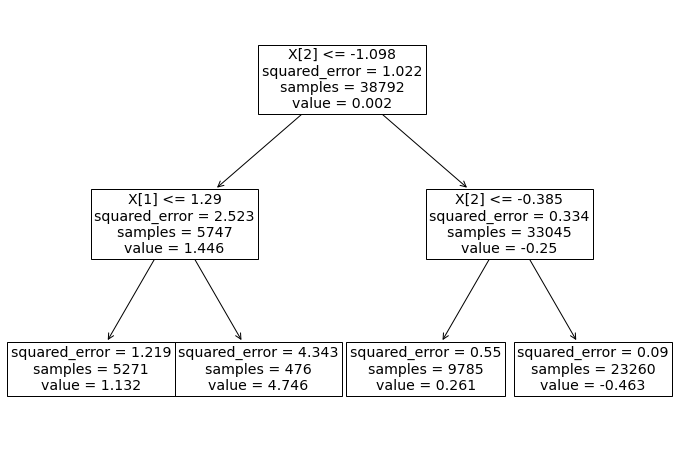

0.6274941221569534


In [469]:
rndForest = RandomForestRegressor(n_estimators = 5, max_depth=2)
rndForest.fit(X_train, y_train)
plot_tree(rndForest.estimators_[0])
plt.show()
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

Widzimy, że modelu `Random Forest` w pierwszych przypadkach poradził sobie całkiem dobrze. Wraz z ograniczeniem hiperparametrów takich jak `max_depth` lub `n_estimators` stopniowo zmniejszała się jego dokładność.

### Model `XGBoost`

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [413]:
xgb_cls.score(X_test, y_test)

0.9348157500700023

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=20, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [416]:
xgb_cls.score(X_test, y_test)

0.9150604152191762

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [418]:
xgb_cls.score(X_test, y_test)

0.8461601044303295

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", max_depth=20, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [420]:
xgb_cls.score(X_test, y_test)

0.939301988323517

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", max_depth=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [422]:
xgb_cls.score(X_test, y_test)

0.9259935864467317

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", max_depth=2, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [424]:
xgb_cls.score(X_test, y_test)

0.8928242866210957

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", max_depth=2, n_estimators=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [426]:
xgb_cls.score(X_test, y_test)

0.6868271681253639

Dla danych bez kolumny `generation_name` model `XGBoost` poradził sobie znacznie lepiej od modelu `Random Forest` gdy hiperparametry `n_estimators` oraz `max_depth` były bardzo ograniczone. W reszcie przypadków model `Random Forest` był lepszy.

## Dane bez wierszy z brakami w kolumnie `generation_name`

### Podział danych na zbiór treningowy, walidacyjny oraz testowy

In [444]:
y = cars_df_del_rows["price"]
X = cars_df_del_rows.drop("price", axis= 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=420, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=420, test_size=0.125)

Proporcje dobrane sa tak by zbiory były podzielone w na 70%/10%/20%

### Model `Random Forest`

In [482]:
rndForest = RandomForestRegressor(n_jobs=-1)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.9489269321628379


In [480]:
rndForest = RandomForestRegressor(n_estimators=10)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.9412895089803002


In [479]:
rndForest = RandomForestRegressor(n_estimators=5)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.9444723064496943


In [481]:
rndForest = RandomForestRegressor(max_depth=20)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.9487539362246785


In [478]:
rndForest = RandomForestRegressor(max_depth=5)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.8470820081503427


In [477]:
rndForest = RandomForestRegressor(max_depth=2)
rndForest.fit(X_train, y_train)
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

0.6317566006910393


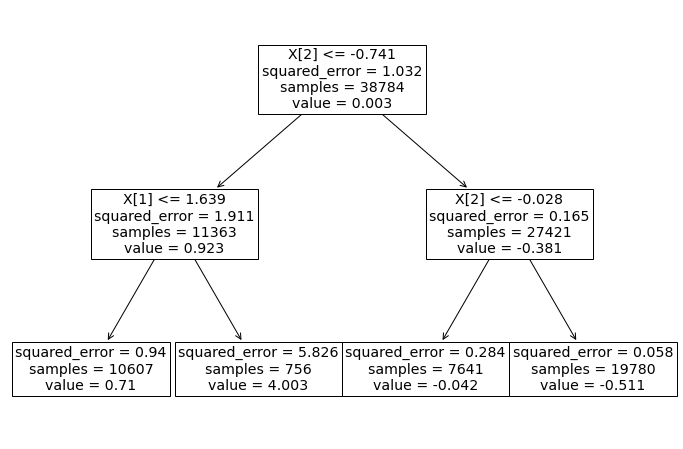

0.6286654468757288


In [476]:
rndForest = RandomForestRegressor(n_estimators = 5, max_depth=2)
rndForest.fit(X_train, y_train)
plot_tree(rndForest.estimators_[0])
plt.show()
y_pred = rndForest.predict(X_val)
print(r2_score(y_val, y_pred))

Widzimy, że raz jeszcze model `Random Forest` sprawił się nieźle. Za wyjątkiem sytuacji, w których hiperparametr `n_estimators` wynosił odpowiednio 10 oraz 5, wraz z ograniczaniem wartości jego oraz hiperparametru `max_depth`, stopniowo malała skuteczność modelu.

### Model `XGBoost`

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [454]:
xgb_cls.score(X_test, y_test)

0.9445394912169993

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=20, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [456]:
xgb_cls.score(X_test, y_test)

0.9249229103821766

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [458]:
xgb_cls.score(X_test, y_test)

0.8560416084959755

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", max_depth=20, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [460]:
xgb_cls.score(X_test, y_test)

0.9465169768061462

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", max_depth=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [462]:
xgb_cls.score(X_test, y_test)

0.9399977843458353

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", max_depth=2, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [464]:
xgb_cls.score(X_test, y_test)

0.9055334159507639

In [ ]:
xgb_cls = xgb.XGBRegressor(objective="reg:squarederror", max_depth=2, n_estimators=5, seed = 420, use_label_encoder=False)
xgb_cls.fit(X_train, y_train, verbose=True, eval_metric="error", eval_set=[(X_val, y_val)])

In [466]:
xgb_cls.score(X_test, y_test)

0.7040029443359179

Sytuacja jest analogiczna do tej z pierwszym zestawem danych, czyli tym niezawierającym kolumny `generation_name`. Model `XGBoost` poradził sobie lepiej dla znacznie ograniczonych wartości hiperparametrów. 

## Wnioski z podziału danych

Okazało się, że drugi model `GXBoost` oparty na danych zawierających wszystkie kolumny poradził sobie lepiej. Kosztem posiadania wszystkich kolumn było usunięcie ok. 25% wierszy, jednak w każdym teście drugi model uzyskał lepszą dokładność.
Dla obu zestawów danych model `Random Forest` miał podobną skuteczność.